# Criando o Banco de Dados #

O primeiro passo é importarmos os dados da FPL e apartir disso criar um DF com os parâmetros os quais consideramremos importantes.

In [91]:
import requests, json
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from pprint import pprint

tqdm.pandas()

# base url for all FPL API endpoints
base_url = 'https://fantasy.premierleague.com/api/'

# Para cada jogador vamos obter os pontos das gw's
def get_gameweek_history(player_id):
    '''get all gameweek info for a given player_id'''
    
    # send GET request to
    # https://fantasy.premierleague.com/api/element-summary/{PID}/
    r = requests.get(
            base_url + 'element-summary/' + str(player_id) + '/'
    ).json()
    
    # extract 'history' data from response into dataframe
    df = pd.json_normalize(r['history'])
    
    return df

# create a players and a team dataframe
r = requests.get(base_url+'bootstrap-static/').json()

players = pd.json_normalize(r['elements'])
teams = pd.json_normalize(r['teams'])

# get position information from 'element_types' field
positions = pd.json_normalize(r['element_types'])

# select columns of interest from players df
players = players[
    ['id', 'first_name', 'second_name', 'web_name', 'team',
     'element_type']
]

# join team name
players = players.merge(
    teams[['id', 'name']],
    left_on='team',
    right_on='id',
    suffixes=['_player', None]
).drop(['team', 'id'], axis=1)

# join player positions
players = players.merge(
    positions[['id', 'singular_name_short']],
    left_on='element_type',
    right_on='id'
).drop(['id'], axis=1)

# Atraves do progress_apply() vamos pegar o historico das gws 
# para cada jogador

points = players['id_player'].progress_apply(get_gameweek_history)

points = pd.concat(df for df in points)

# join web_name
points = players[['id_player', 'web_name', 'element_type']].merge(
    points,
    left_on='id_player',
    right_on='element'
)

  0%|          | 0/661 [00:00<?, ?it/s]

In [92]:
points.columns

Index(['id_player', 'web_name', 'element_type', 'element', 'fixture',
       'opponent_team', 'total_points', 'was_home', 'kickoff_time',
       'team_h_score', 'team_a_score', 'round', 'minutes', 'goals_scored',
       'assists', 'clean_sheets', 'goals_conceded', 'own_goals',
       'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards',
       'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat',
       'ict_index', 'value', 'transfers_balance', 'selected', 'transfers_in',
       'transfers_out'],
      dtype='object')

A intensão aqui é conseguirmos predizer o valor de um jogador APÓS uma rodada. Ou seja, quais parâmetros (gols feitos, gols sofridos, posição, minutos jogados...) possuem maior impacto na volatilidade do preço de um jogador para a próxima rodada.

In [6]:
points = points[['id_player', 'web_name', 'element_type', 'fixture', 'opponent_team',
                'total_points', 'was_home', 'ict_index', 'team_h_score', 'team_a_score',
                'minutes', 'goals_scored', 'assists', 'red_cards', 'saves', 'bonus', 'value']]

In [7]:
points.head()

,id_player,web_name,element,fixture,opponent_team,total_points,was_home,ict_index,team_h_score,team_a_score,minutes,goals_scored,assists,red_cards,saves,bonus,value
0,1,Leno,1,1,3,1,False,1.2,2,0,90,0,0,0,1,0,50
1,1,Leno,1,18,6,2,True,2.4,0,2,90,0,0,0,3,0,50
2,1,Leno,1,24,12,1,False,4.3,5,0,90,0,0,0,5,0,49
3,1,Leno,1,31,15,0,True,0.0,1,0,0,0,0,0,0,0,49
4,1,Leno,1,43,5,0,False,0.0,0,1,0,0,0,0,0,0,49


In [8]:
# DataFrame com as GW's do Salah
pts_salah = points[points.web_name == 'Salah'] 

pts_salah

,id_player,web_name,element,fixture,opponent_team,total_points,was_home,ict_index,team_h_score,team_a_score,minutes,goals_scored,assists,red_cards,saves,bonus,value
3466,233,Salah,233,7,15,17,False,17.7,0,3,90,1,2,0,0,3,125
3467,233,Salah,233,15,5,3,True,11.1,2,0,90,0,0,0,0,0,126
3468,233,Salah,233,23,6,10,True,14.0,1,1,90,1,0,0,0,3,126
3469,233,Salah,233,36,10,8,False,17.7,0,3,90,1,0,0,0,0,125
3470,233,Salah,233,44,7,12,True,19.7,3,0,90,1,1,0,0,2,125
3471,233,Salah,233,52,3,7,False,9.8,3,3,90,1,0,0,0,0,126
3472,233,Salah,233,66,12,13,True,15.7,2,2,90,1,1,0,0,3,126
3473,233,Salah,233,80,18,13,False,18.6,0,5,90,1,1,0,0,2,127
3474,233,Salah,233,88,13,24,False,24.5,0,5,90,3,1,0,0,3,128
3475,233,Salah,233,94,4,5,True,10.4,2,2,90,0,1,0,0,0,129


In [10]:
# vamos retirar a tabela do link da bbc
# assim as posições estarão sempre atualizadas
prem_table = pd.read_html('https://www.bbc.co.uk/sport/football/premier-league/table')
Premier_table = prem_table[0]

Premier_league = Premier_table.drop(['Unnamed: 1', 'Form'], axis=1)
Premier_league = Premier_league.drop([20])

Premier_league.rename(columns={'Unnamed: 0': 'Pos'}, inplace=True)

Premier_league[['Pos','P', 'W', 'D', 'L','F','A','GD','Pts']] = Premier_league[['Pos','P', 'W', 
                                                                                'D','L','F','A',
                                                                                'GD','Pts']].apply(pd.to_numeric)
# necessario para evitar problemas de mapeamento
teams.loc[teams.name == 'Spurs', 'name'] = 'Tottenham'


# cria a coluna de pos adversarias
pos = []

for opponent_team in pts_salah['opponent_team'].values:
    team_name = teams.loc[teams.id == opponent_team, ['name']].values
    pos_team = Premier_league.loc[Premier_league.Team == team_name[0][0], ['Pos']].values
    
    pos.append(pos_team[0][0])
    
# cria uma coluna no DF com a posicao dos adversarios    
pts_salah['opponent_pos'] = np.array(pos)
pts_salah = pts_salah.drop(['opponent_team'], axis=1)

pts_salah.head()

/home/crohma/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id_player,web_name,element,fixture,total_points,was_home,ict_index,team_h_score,team_a_score,minutes,goals_scored,assists,red_cards,saves,bonus,value,opponent_pos
3466,233,Salah,233,7,17,False,17.7,0,3,90,1,2,0,0,3,125,20
3467,233,Salah,233,15,3,True,11.1,2,0,90,0,0,0,0,0,126,18
3468,233,Salah,233,23,10,True,14.0,1,1,90,1,0,0,0,3,126,3
3469,233,Salah,233,36,8,False,17.7,0,3,90,1,0,0,0,0,125,16
3470,233,Salah,233,44,12,True,19.7,3,0,90,1,1,0,0,2,125,11


In [12]:
# retira algumas colunas desnecessárias para a análise

pts_salah = pts_salah.drop(['id_player', 'web_name', 'element', 'fixture'],
                          axis=1)
pts_salah.head()

,total_points,was_home,ict_index,team_h_score,team_a_score,minutes,goals_scored,assists,red_cards,saves,bonus,value,opponent_pos
3466,17,False,17.7,0,3,90,1,2,0,0,3,125,20
3467,3,True,11.1,2,0,90,0,0,0,0,0,126,18
3468,10,True,14.0,1,1,90,1,0,0,0,3,126,3
3469,8,False,17.7,0,3,90,1,0,0,0,0,125,16
3470,12,True,19.7,3,0,90,1,1,0,0,2,125,11


Vamos agora criar duas outras colunas. Uma coluna com os gols feitos pelo time do jogador na partida e outra com os gols sofridos. Essa informação deve ser mais importante que os parâmetros de gols em casa e fora.

In [33]:
team_gols = []
adv_gols = []

for fixture in pts_salah.index:
    if pts_salah.loc[fixture].was_home ==  True:
        team_gols.append(pts_salah.loc[fixture].team_h_score)
        adv_gols.append(pts_salah.loc[fixture].team_a_score)
    else:
        team_gols.append(pts_salah.loc[fixture].team_a_score)
        adv_gols.append(pts_salah.loc[fixture].team_h_score)

In [34]:
pts_salah['team_gols'] = team_gols
pts_salah['adv_gols'] = adv_gols

In [36]:
pts_salah = pts_salah.drop(['team_h_score', 'team_a_score'], axis=1)

pts_salah.head()

,total_points,was_home,ict_index,minutes,goals_scored,assists,red_cards,saves,bonus,value,opponent_pos,team_gols,adv_gols
3466,17,False,17.7,90,1,2,0,0,3,125,20,3,0
3467,3,True,11.1,90,0,0,0,0,0,126,18,2,0
3468,10,True,14.0,90,1,0,0,0,3,126,3,1,1
3469,8,False,17.7,90,1,0,0,0,0,125,16,3,0
3470,12,True,19.7,90,1,1,0,0,2,125,11,3,0


<AxesSubplot:>

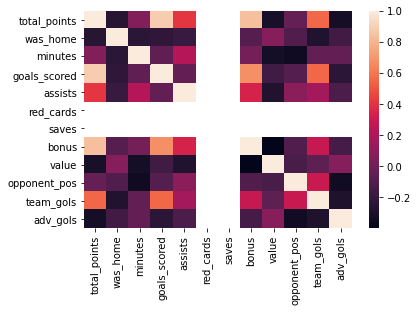

In [39]:
import seaborn as sns

sns.heatmap(pts_salah.corr())

Essa cruz no centro é um indicativo de que o jogador em questão não tomou nenhum cartão vermelho na amostra nem realizou nenhuma defesa. De fato:

In [44]:
pts_salah.saves.describe();
pts_salah.red_cards.describe()

count    18.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: red_cards, dtype: float64

<AxesSubplot:>

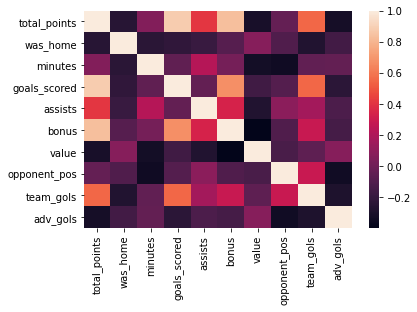

In [45]:
# remove as duas colunas
pts_salah = pts_salah.drop(['saves', 'red_cards'], axis=1)

sns.heatmap(pts_salah.corr())

Agora só resta realizarmos o tratamento da variável preditora 'was_home' através do uso de dummy variables:

In [46]:
dummies = pd.get_dummies(pts_salah['was_home'], prefix='home')
pts_salah = pd.concat([pts_salah, dummies], axis=1)

pts_salah.drop(['was_home'], inplace=True, axis=1)

pts_salah.head()

,total_points,ict_index,minutes,goals_scored,assists,bonus,value,opponent_pos,team_gols,adv_gols,home_False,home_True
3466,17,17.7,90,1,2,3,125,20,3,0,1,0
3467,3,11.1,90,0,0,0,126,18,2,0,0,1
3468,10,14.0,90,1,0,3,126,3,1,1,0,1
3469,8,17.7,90,1,0,0,125,16,3,0,1,0
3470,12,19.7,90,1,1,2,125,11,3,0,0,1


Vamos converter o tipo da coluna 'ict_index', que foi identificado como um 'object'.

In [65]:
pts_salah.ict_index = pd.to_numeric(pts_salah.ict_index)

pts_salah.dtypes

total_points      int64
ict_index       float64
minutes           int64
goals_scored      int64
assists           int64
bonus             int64
value             int64
opponent_pos      int64
team_gols         int64
adv_gols          int64
home_False        uint8
home_True         uint8
dtype: object

In [66]:
import statsmodels.formula.api as smf

regression_model = 'value ~ total_points + ict_index + minutes + goals_scored + assists + bonus + opponent_pos + team_gols + adv_gols + home_True'

regression_output = smf.ols(regression_model, pts_salah).fit()

print(regression_output.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     1.313
Date:                Mon, 20 Dec 2021   Prob (F-statistic):              0.369
Time:                        18:35:24   Log-Likelihood:                -30.414
No. Observations:                  18   AIC:                             82.83
Df Residuals:                       7   BIC:                             92.62
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      151.5348     15.476      9.792   

/home/crohma/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


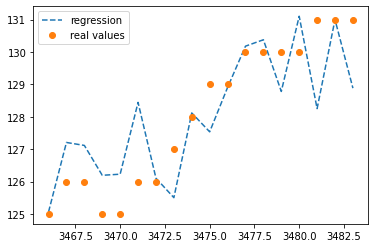

In [75]:
import matplotlib.pyplot as plt

plt.plot(regression_output.fittedvalues, '--',label = 'regression')
plt.plot(pts_salah.value, 'o', label = 'real values')

plt.legend()

plt.show()

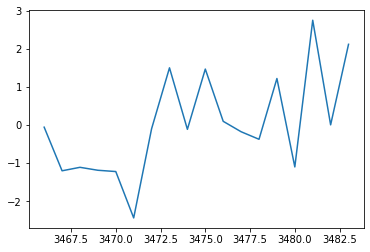

In [76]:
plt.plot(regression_output.resid)
plt.show()

# Base de dados para os atacantes #

In [109]:
points.columns

Index(['id_player', 'web_name', 'element_type', 'element', 'fixture',
       'opponent_team', 'total_points', 'was_home', 'kickoff_time',
       'team_h_score', 'team_a_score', 'round', 'minutes', 'goals_scored',
       'assists', 'clean_sheets', 'goals_conceded', 'own_goals',
       'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards',
       'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat',
       'ict_index', 'value', 'transfers_balance', 'selected', 'transfers_in',
       'transfers_out'],
      dtype='object')

In [110]:
fowards_points = points.loc[points['element_type'] == 4]

fowards_points.head()

,id_player,web_name,element_type,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,...,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out
5453,4,Aubameyang,4,4,1,3,0,False,2021-08-13T19:00:00Z,2,...,0,0.0,0.0,0.0,0.0,100,0,200068,0,0
5454,4,Aubameyang,4,4,18,6,1,True,2021-08-22T15:30:00Z,0,...,5,5.0,1.3,19.0,2.5,99,-106222,93597,1147,107369
5455,4,Aubameyang,4,4,24,12,1,False,2021-08-28T11:30:00Z,5,...,0,0.0,1.4,0.0,0.1,99,-10890,93954,11676,22566
5456,4,Aubameyang,4,4,31,15,9,True,2021-09-11T14:00:00Z,1,...,30,35.8,22.5,103.0,16.1,99,56011,167315,93463,37452
5457,4,Aubameyang,4,4,43,5,2,False,2021-09-18T14:00:00Z,0,...,6,7.2,37.4,18.0,6.3,99,21567,190778,49181,27614


In [111]:
# cria a coluna de pos adversarias
pos = []

for opponent_team in fowards_points['opponent_team'].values:
    team_name = teams.loc[teams.id == opponent_team, ['name']].values
    pos_team = Premier_league.loc[Premier_league.Team == team_name[0][0], ['Pos']].values
    
    pos.append(pos_team[0][0])
    
# cria uma coluna no DF com a posicao dos adversarios    
fowards_points['opponent_pos'] = np.array(pos)
fowards_points = fowards_points.drop(['opponent_team'], axis=1)

fowards_points.head()

/home/crohma/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,id_player,web_name,element_type,element,fixture,total_points,was_home,kickoff_time,team_h_score,team_a_score,...,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,opponent_pos
5453,4,Aubameyang,4,4,1,0,False,2021-08-13T19:00:00Z,2,0,...,0.0,0.0,0.0,0.0,100,0,200068,0,0,12
5454,4,Aubameyang,4,4,18,1,True,2021-08-22T15:30:00Z,0,2,...,5.0,1.3,19.0,2.5,99,-106222,93597,1147,107369,3
5455,4,Aubameyang,4,4,24,1,False,2021-08-28T11:30:00Z,5,0,...,0.0,1.4,0.0,0.1,99,-10890,93954,11676,22566,1
5456,4,Aubameyang,4,4,31,9,True,2021-09-11T14:00:00Z,1,0,...,35.8,22.5,103.0,16.1,99,56011,167315,93463,37452,20
5457,4,Aubameyang,4,4,43,2,False,2021-09-18T14:00:00Z,0,1,...,7.2,37.4,18.0,6.3,99,21567,190778,49181,27614,18


In [112]:
team_gols = []
adv_gols = []

for fixture in fowards_points.index:
    if fowards_points.loc[fixture].was_home ==  True:
        team_gols.append(fowards_points.loc[fixture].team_h_score)
        adv_gols.append(fowards_points.loc[fixture].team_a_score)
    else:
        team_gols.append(fowards_points.loc[fixture].team_a_score)
        adv_gols.append(fowards_points.loc[fixture].team_h_score)
        
fowards_points['team_gols'] = team_gols
fowards_points['adv_gols'] = adv_gols


fowards_points = fowards_points[['id_player', 'web_name', 'element_type', 'fixture', 
                                 'total_points', 'was_home', 'ict_index', 'team_gols', 'adv_gols',
                                 'minutes', 'goals_scored', 'assists', 'red_cards', 'saves', 'bonus', 'opponent_pos',
                                 'value']]

In [113]:
fowards_points.head()

,id_player,web_name,element_type,fixture,total_points,was_home,ict_index,team_gols,adv_gols,minutes,goals_scored,assists,red_cards,saves,bonus,opponent_pos,value
5453,4,Aubameyang,4,1,0,False,0.0,0,2,0,0,0,0,0,0,12,100
5454,4,Aubameyang,4,18,1,True,2.5,0,2,29,0,0,0,0,0,3,99
5455,4,Aubameyang,4,24,1,False,0.1,0,5,58,0,0,0,0,0,1,99
5456,4,Aubameyang,4,31,9,True,16.1,1,0,90,1,0,0,0,3,20,99
5457,4,Aubameyang,4,43,2,False,6.3,1,0,90,0,0,0,0,0,18,99


In [114]:
dummies = pd.get_dummies(fowards_points['was_home'], prefix='home')
fowards_points = pd.concat([fowards_points, dummies], axis=1)

fowards_points.drop(['was_home'], inplace=True, axis=1)

fowards_points.ict_index = pd.to_numeric(fowards_points.ict_index)

fowards_points.dtypes

id_player         int64
web_name         object
element_type      int64
fixture           int64
total_points      int64
ict_index       float64
team_gols         int64
adv_gols          int64
minutes           int64
goals_scored      int64
assists           int64
red_cards         int64
saves             int64
bonus             int64
opponent_pos      int64
value             int64
home_False        uint8
home_True         uint8
dtype: object

# Regressão para os atacantes #

<AxesSubplot:>

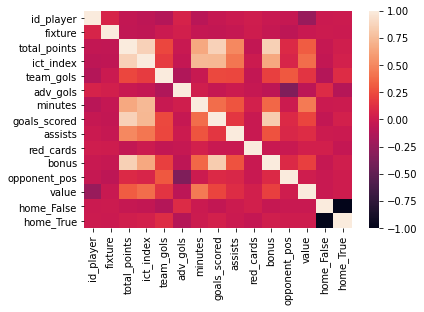

In [115]:
# remove os parametros irrelevantes pra análise
fowards_points = fowards_points.drop(['saves', 'element_type'],axis=1)

# gera o grafico de correlacao
sns.heatmap(fowards_points.corr())

In [116]:
regression_model = 'value ~ total_points + ict_index + minutes + goals_scored + assists + bonus + opponent_pos + team_gols + adv_gols + home_True'

regression_output = smf.ols(regression_model, fowards_points).fit()

print(regression_output.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     42.80
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           2.47e-74
Time:                        21:15:45   Log-Likelihood:                -5846.2
No. Observations:                1413   AIC:                         1.171e+04
Df Residuals:                    1402   BIC:                         1.177e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       57.0413      1.282     44.509   

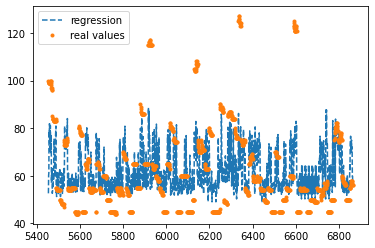

In [120]:
plt.plot(regression_output.fittedvalues, '--',label = 'regression')
plt.plot(fowards_points.value, '.', label = 'real values')

plt.legend()

plt.show()

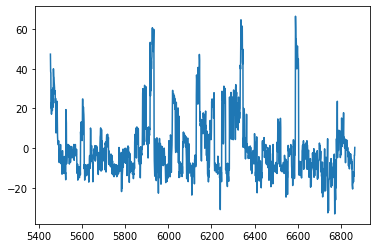

In [121]:
plt.plot(regression_output.resid)
plt.show()